In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load and clean data
df = pd.read_csv("train.csv")
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())

# Fill missing categorical and numerical values
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include='number').columns.drop("SalePrice")

df[categorical_cols] = df[categorical_cols].fillna("None")
df[numerical_cols] = df[numerical_cols].fillna(0)

# One-hot encode
df = pd.get_dummies(df, columns=categorical_cols)

# Log-transform target
df["SalePrice"] = np.log1p(df["SalePrice"])

# Split features and target
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_preds_log = xgb_model.predict(X_test)
xgb_preds = np.expm1(xgb_preds_log)
y_test_actual = np.expm1(y_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test_actual, xgb_preds))
xgb_r2 = r2_score(y_test_actual, xgb_preds)
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")

XGBoost RMSE: 27296.43, R²: 0.8932


In [5]:
import pandas as pd
import numpy as np

# Predict on test set
xgb_preds_log = xgb_model.predict(X_test)
xgb_preds = np.expm1(xgb_preds_log)  # Convert back from log scale
y_test_actual = np.expm1(y_test)     # Convert actual prices back

# Create a DataFrame with results
results_df = pd.DataFrame({
    "ActualPrice": y_test_actual,
    "PredictedPrice": xgb_preds
})

# Calculate error metrics
results_df["AbsoluteError"] = np.abs(results_df["PredictedPrice"] - results_df["ActualPrice"])
results_df["ErrorPercent"] = 100 * results_df["AbsoluteError"] / results_df["ActualPrice"]

# Round for readability
results_df = results_df.round(2)

# Display first 20 rows
print(results_df.head(20))

      ActualPrice  PredictedPrice  AbsoluteError  ErrorPercent
892      154500.0   145262.953125        9237.05          5.98
1105     325000.0   326991.937500        1991.94          0.61
413      115000.0   120437.609375        5437.61          4.73
522      159000.0   164103.046875        5103.05          3.21
1036     315500.0   319729.531250        4229.53          1.34
614       75500.0    74517.976562         982.02          1.30
218      311500.0   223416.875000       88083.13         28.28
1160     146000.0   146872.296875         872.30          0.60
649       84500.0    76024.343750        8475.66         10.03
887      135500.0   127566.031250        7933.97          5.86
576      145000.0   157933.312500       12933.31          8.92
1252     130000.0   121125.742188        8874.26          6.83
1061      81000.0   108254.648438       27254.65         33.65
567      214000.0   203517.015625       10482.98          4.90
1108     181000.0   174139.593750        6860.39       

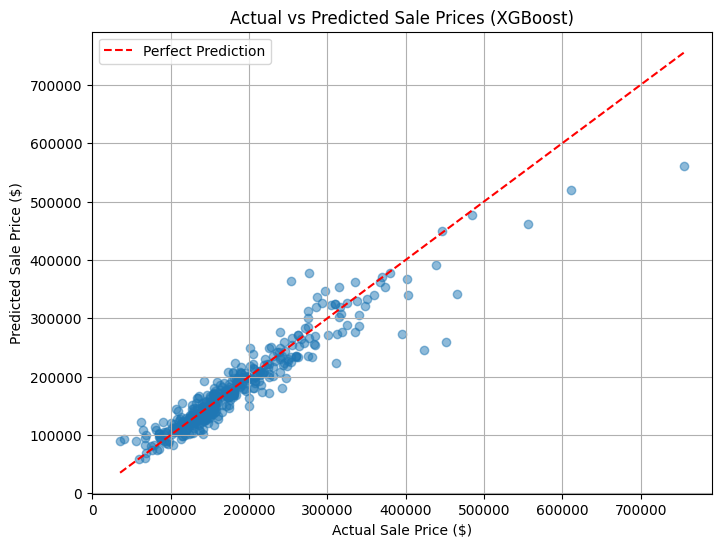

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(results_df["ActualPrice"], results_df["PredictedPrice"], alpha=0.5)
plt.plot([results_df["ActualPrice"].min(), results_df["ActualPrice"].max()],
         [results_df["ActualPrice"].min(), results_df["ActualPrice"].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.title("Actual vs Predicted Sale Prices (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Group by price ranges and check average error
results_df["PriceRange"] = pd.cut(results_df["ActualPrice"], bins=[0, 100000, 200000, 300000, 400000, 500000, np.inf])
grouped = results_df.groupby("PriceRange")[["AbsoluteError", "ErrorPercent"]].mean().round(2)
print(grouped)

                      AbsoluteError  ErrorPercent
PriceRange                                       
(0.0, 100000.0]            17724.73         27.54
(100000.0, 200000.0]       10525.85          7.23
(200000.0, 300000.0]       21550.54          8.87
(300000.0, 400000.0]       28658.36          8.54
(400000.0, 500000.0]       81175.96         18.56
(500000.0, inf]           126971.95         19.26


C:\Users\himan\AppData\Local\Temp\ipykernel_14988\3064264036.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = results_df.groupby("PriceRange")[["AbsoluteError", "ErrorPercent"]].mean().round(2)
